In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import plotnine as p9
import scanpy as sc

In [2]:
p9.options.dpi=300
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype']='none' 

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300)

In [5]:
D0_adata=sc.read_h5ad(D0data_dir+'/OAK1to20_GEXwLineage_normalized.h5ad')

In [6]:
fc_lineage=pd.read_csv(D0data_dir+'/D0toD20_lineage_change.csv',header=0)

In [7]:
fc_lineage['fc_category']=''
fc_lineage.loc[(fc_lineage['T0oak1to20_NumCells']>9) & (fc_lineage['fc_D20overD0']<0.4),'fc_category']='Most_depleted'
fc_lineage.loc[(fc_lineage['T0oak1to20_NumCells']>9) & (fc_lineage['fc_D20overD0']>9),'fc_category']='Most_enriched'

In [8]:
D0_adata.obs=D0_adata.obs.reset_index().merge(fc_lineage,how="left",left_on=['Lineage_assigned'],right_on=['LineageID']).set_index('index')

In [9]:
adata_D0_2ends = D0_adata[D0_adata.obs['fc_category'].isin(['Most_enriched','Most_depleted']),:]

In [11]:
sc.tl.rank_genes_groups(adata_D0_2ends, 'fc_category', method='wilcoxon')


ranking genes


/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Lineage_assigned' as categorical
/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
Trying to set attribute `.obs` of view, copying.
... storing 'LineageID' as categorical
/gstore/home/wub31/.co

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


In [31]:
# adata_D0_2ends.write(D0data_dir+'/AggD0_2ends.h5ad')

In [10]:
adata_D0_2ends=sc.read_h5ad(D0data_dir+'/AggD0_2ends.h5ad')

In [11]:
D0_cluster_compare = adata_D0_2ends.uns['rank_genes_groups']
D0_groups = D0_cluster_compare['names'].dtype.names
df_D0_cluster_compare=pd.DataFrame(
    {group + '_' + key[:1]: D0_cluster_compare[key][group]
    for group in D0_groups for key in ['names','pvals_adj','logfoldchanges']})
#the logfoldchanges are log2

In [12]:
df_D0_DE_plot=df_D0_cluster_compare[['Most_enriched_n','Most_enriched_p','Most_enriched_l']]

In [13]:
df_D0_DE_plot['-log10_p_adj']=-np.log10(df_D0_DE_plot['Most_enriched_p'])

/local/18178517/ipykernel_6250/1178368582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


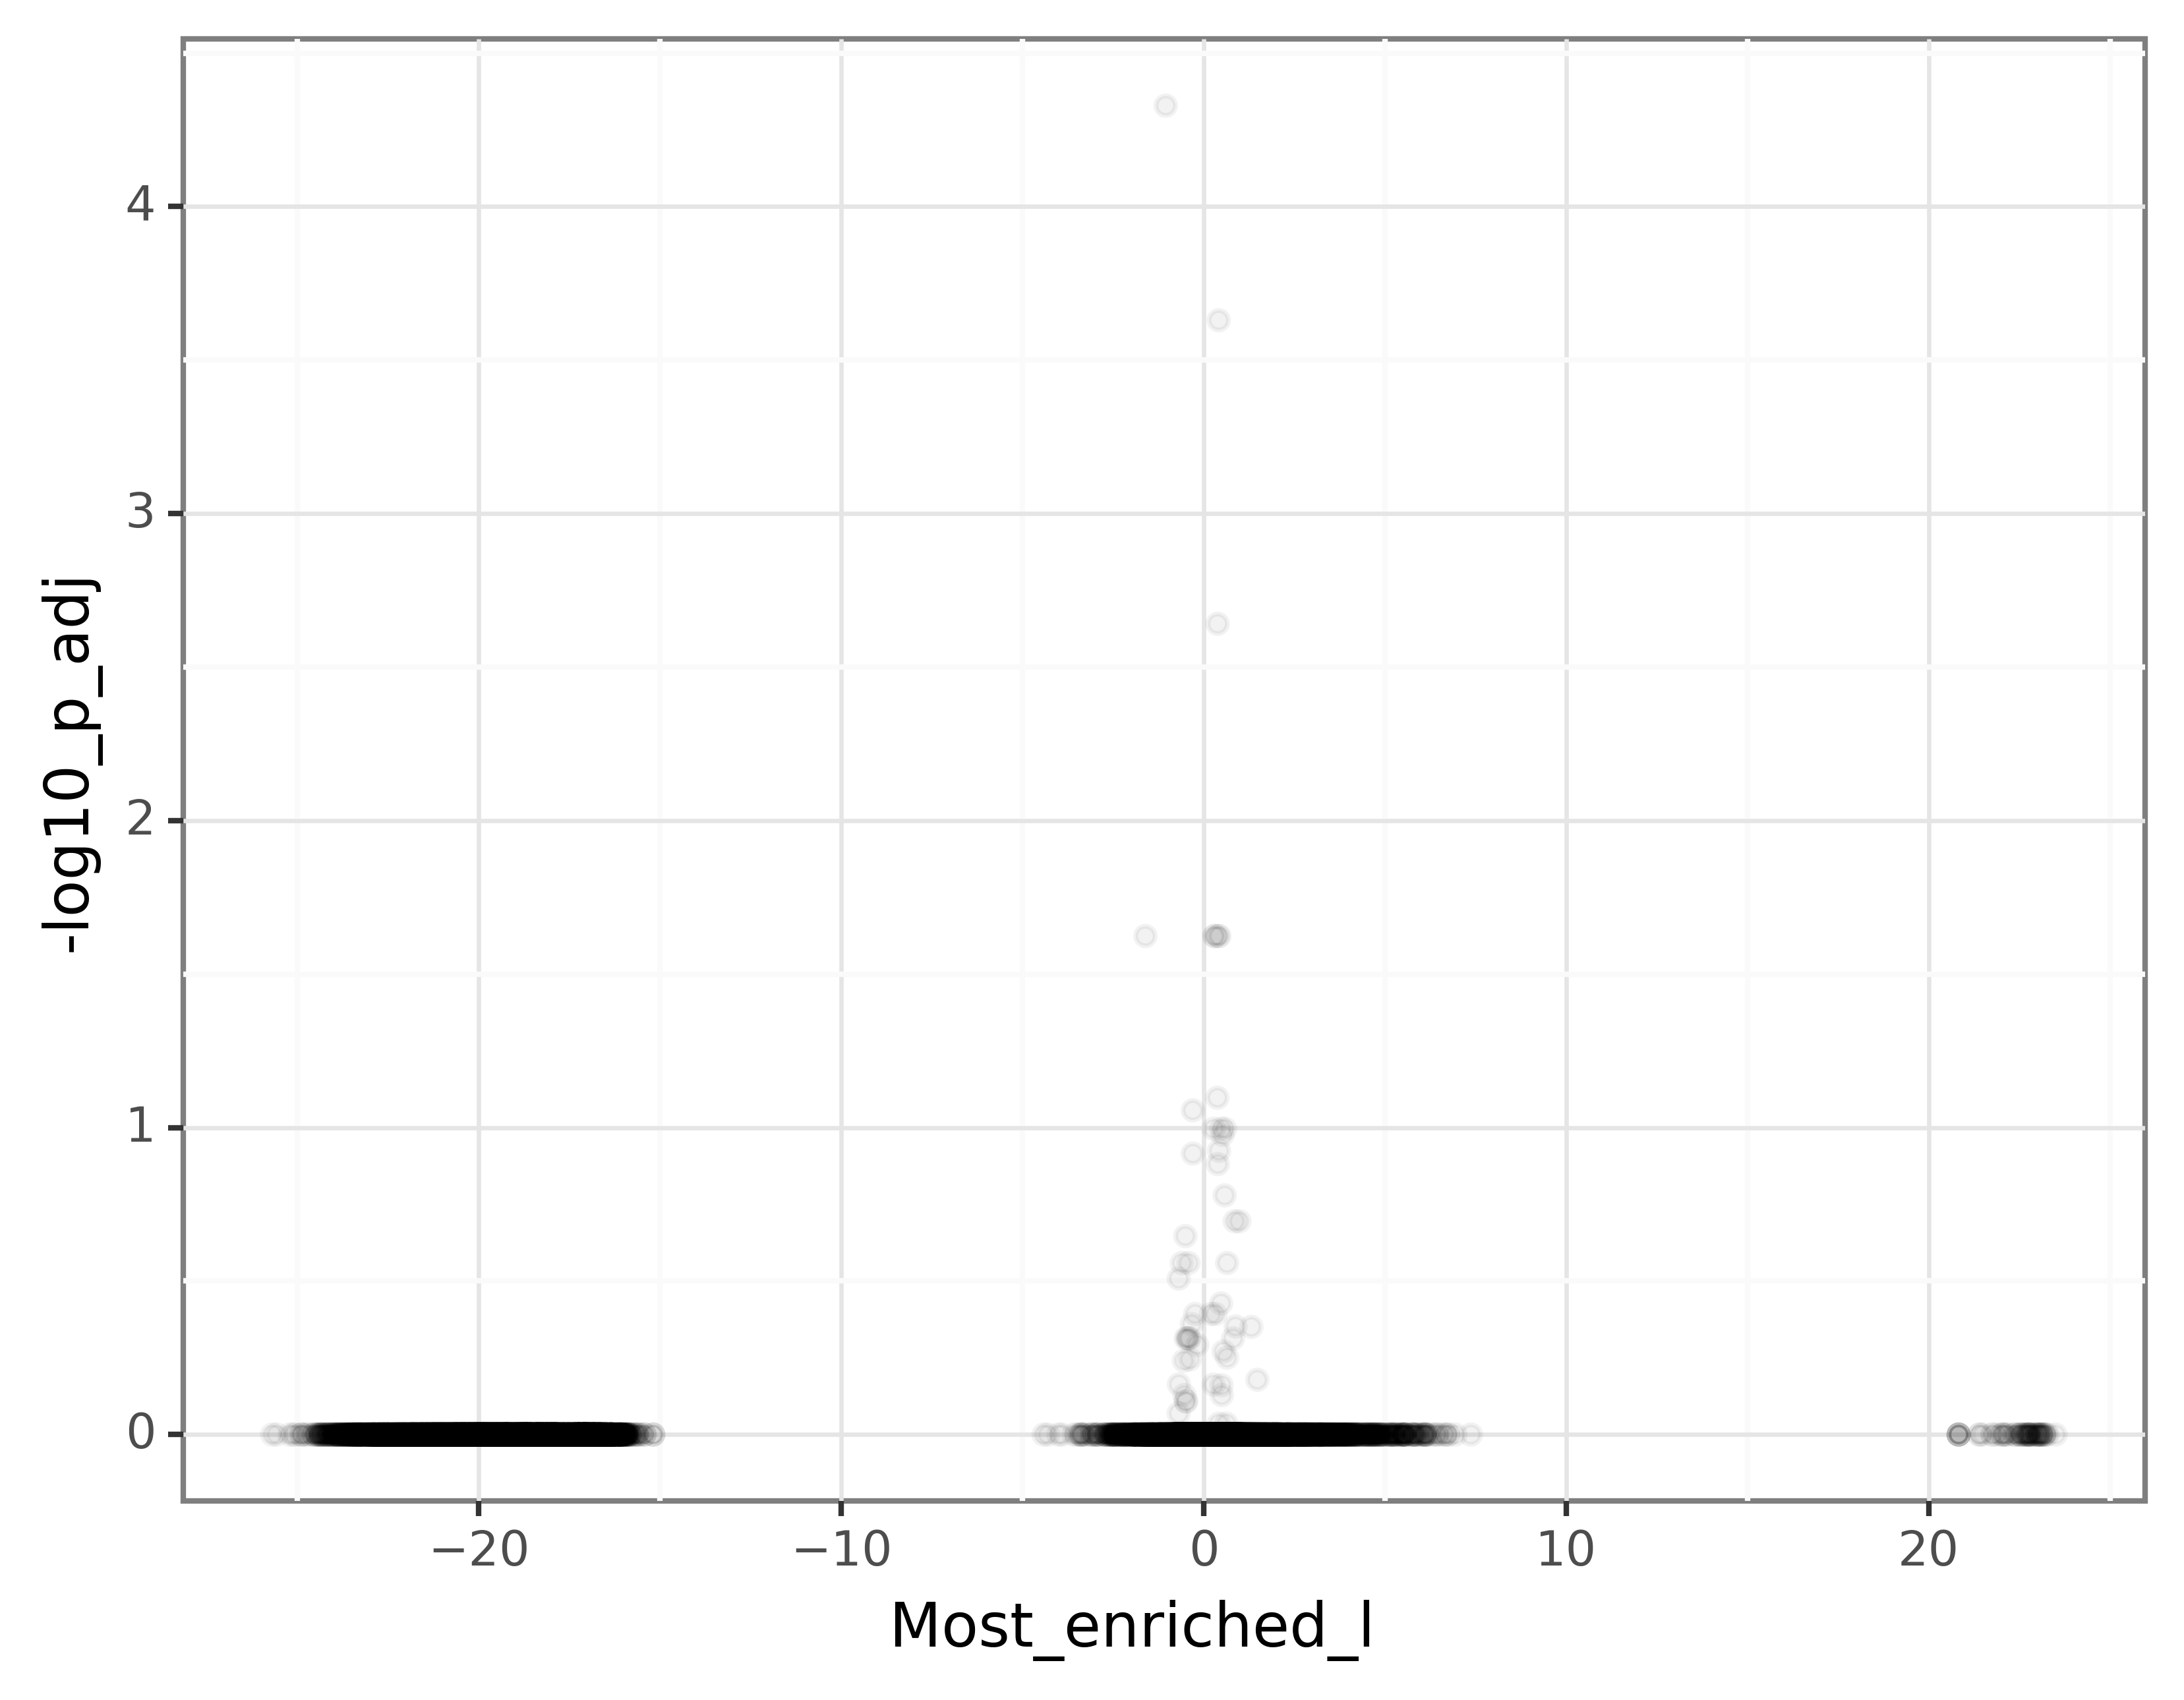

<ggplot: (2932274377704)>

In [14]:
plot = p9.ggplot(data=df_D0_DE_plot,
                mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj'))
plot+ p9.themes.theme_bw() \
    + p9.geom_point(alpha = 0.05) 

In [15]:
D0_LabelList=(df_D0_DE_plot[df_D0_DE_plot['Most_enriched_p']<0.05].Most_enriched_n).tolist()

In [16]:
df_D0_DE_plot['GOI']=[x in D0_LabelList for x in df_D0_DE_plot.Most_enriched_n]

/local/18178517/ipykernel_6250/1436721861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
df_D0_DE_plot['point_color']=['High_enriched' if (x.GOI==True)&(x.Most_enriched_l>0) \
                          else 'High_depleted' if (x.GOI==True)&(x.Most_enriched_l<0) \
                          else 'Others' for index, x in df_D0_DE_plot.iterrows()]

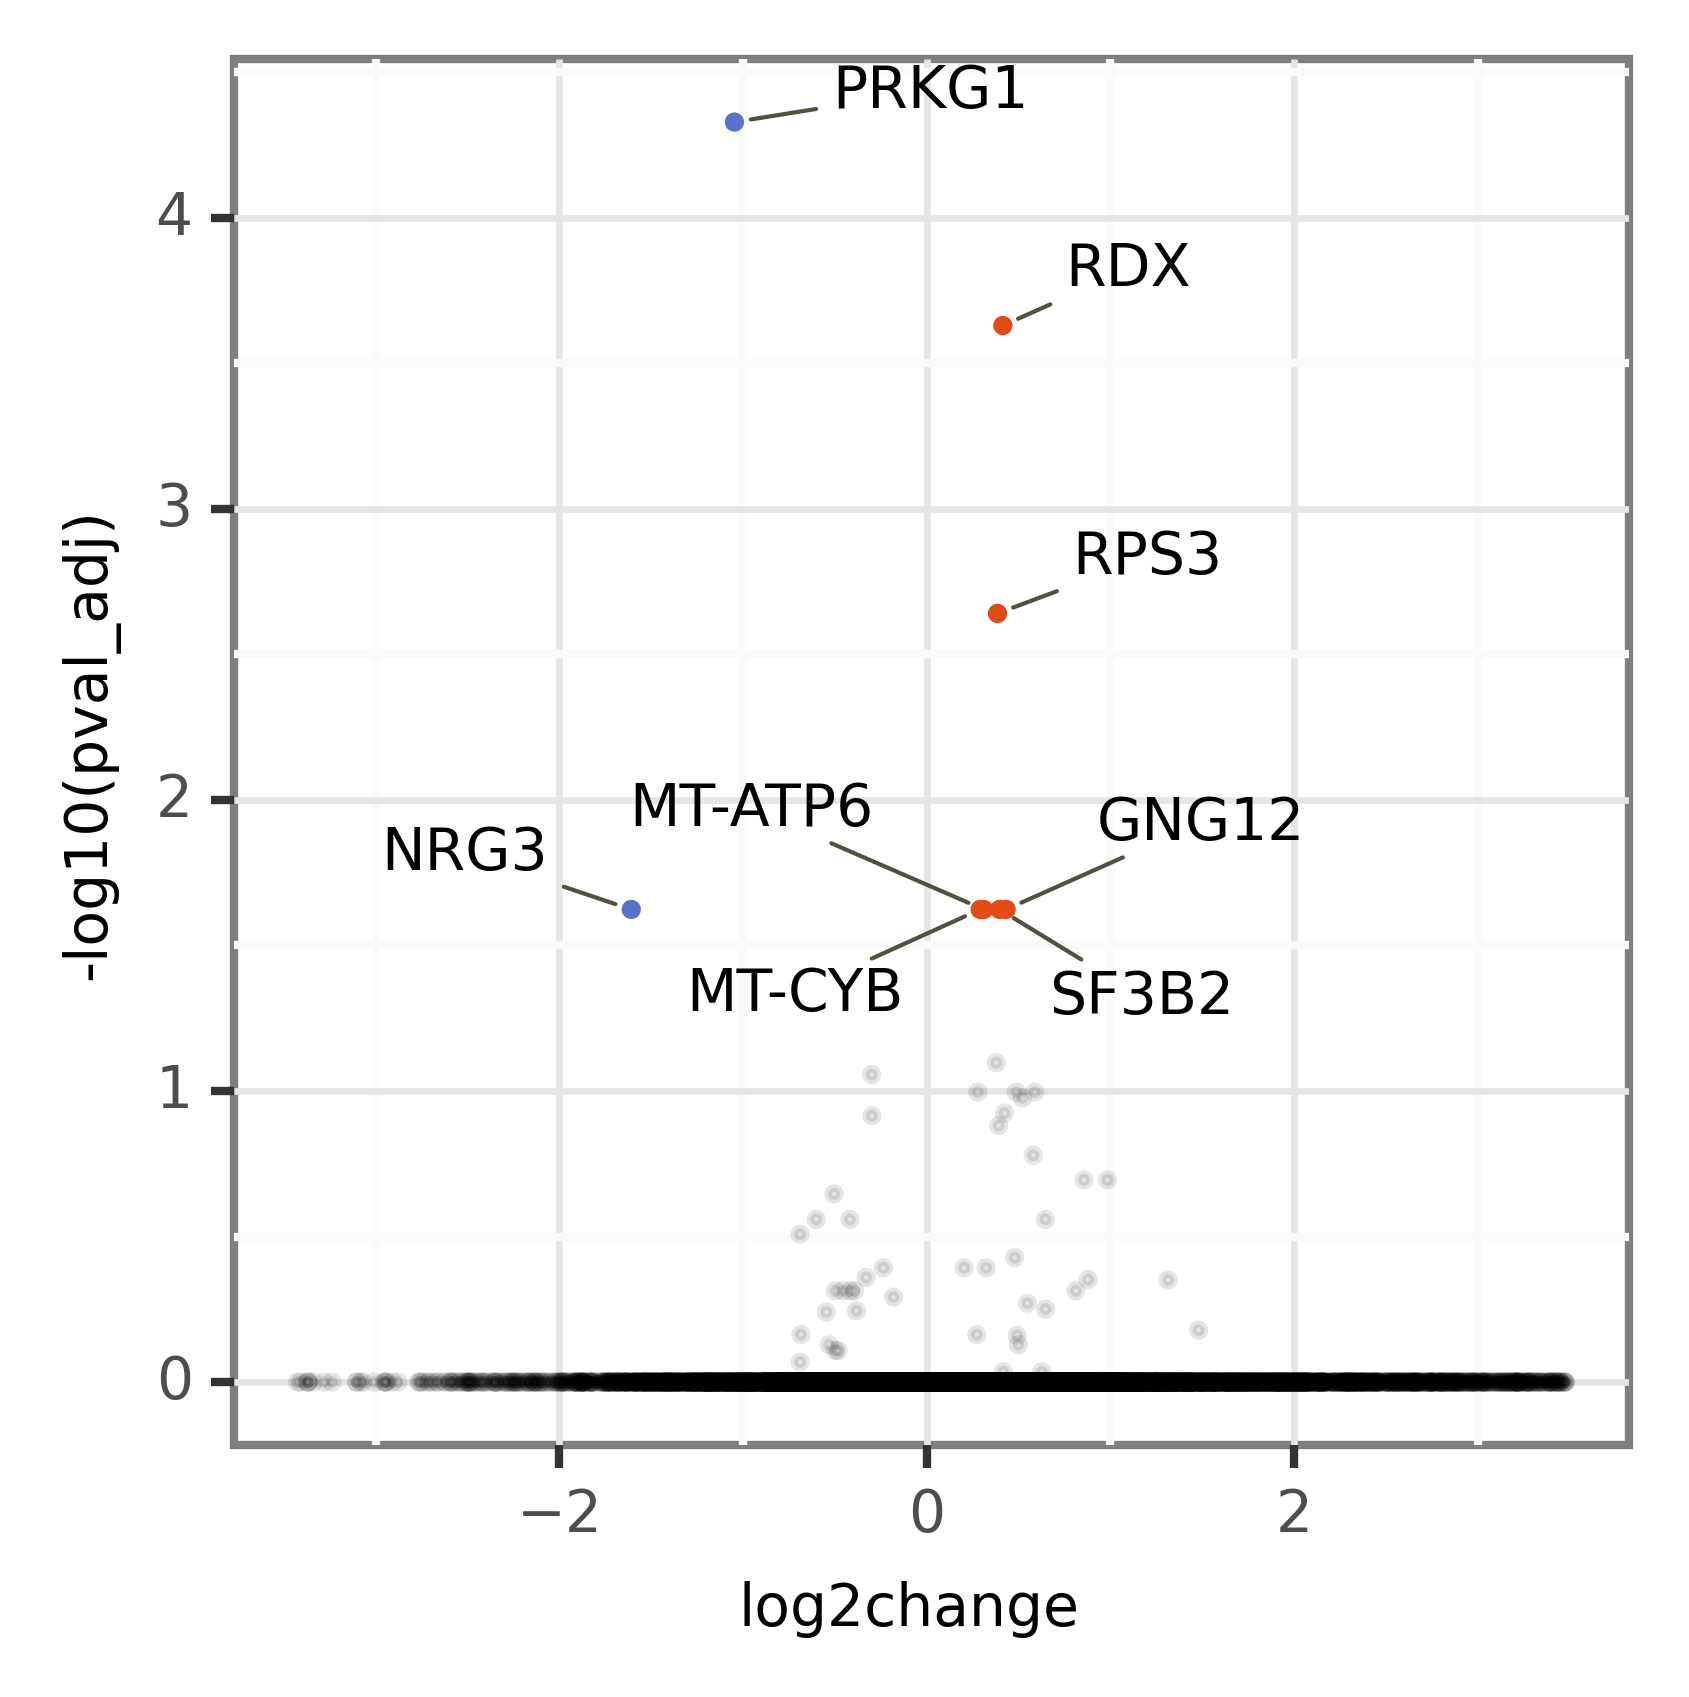

<ggplot: (2932242961396)>

In [18]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color':'#4E523F',
        'lw':0.5
    }
}
plot = p9.ggplot(data=df_D0_DE_plot[(df_D0_DE_plot.Most_enriched_l<3.5) & (df_D0_DE_plot.Most_enriched_l>-3.5)],
                mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj'))
plot+ p9.themes.theme_bw() \
    + p9.geom_point(alpha=0.1,size=0.3) \
    + p9.geom_point(data=df_D0_DE_plot[df_D0_DE_plot.GOI==True],mapping=p9.aes(color='point_color'),size=0.3) \
    + p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_D0_DE_plot[df_D0_DE_plot.GOI==True],mapping=p9.aes(x='Most_enriched_l',y='-log10_p_adj',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
    + p9.ylab('-log10(pval_adj)') \
    + p9.xlab('log2change') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
    + p9.theme(figure_size=(3,3))

In [19]:
adata_D20_2ends=sc.read_h5ad(D20data_dir+'/AggD20_2ends.h5ad')

In [20]:
cluster_compare_D20 = adata_D20_2ends.uns['rank_genes_groups']
groups_D20 = cluster_compare_D20['names'].dtype.names
df_cluster_compare_Day20=pd.DataFrame(
    {group + '_' + key[:1]: cluster_compare_D20[key][group]
    for group in groups_D20 for key in ['names','pvals_adj','logfoldchanges']})
#the logfoldchanges are log2
#use the p values that are adjusted

In [21]:
df_D20_DE_plot=df_cluster_compare_Day20[['Most_enriched_n','Most_enriched_p','Most_enriched_l']]

In [22]:
df_DE_merge=df_D0_DE_plot.reset_index().merge(df_D20_DE_plot,how='left',left_on=['Most_enriched_n'],right_on=['Most_enriched_n'])
# _x is for D0. _y is for D20.

In [23]:
df_DE_merge['-log10_p_adj_D20']=-np.log10(df_DE_merge['Most_enriched_p_y'])

In [24]:
LabelList_merge=(df_DE_merge[((df_DE_merge['-log10_p_adj_D20']>8)&(df_DE_merge['Most_enriched_l_y']<-0.5)) | ((df_DE_merge['-log10_p_adj_D20']>8)&(df_DE_merge['Most_enriched_l_y']>0.5))].Most_enriched_n).tolist()
#Keep label genes the same as in the D20 vocalno plot

In [25]:
df_DE_merge['GOI_merge']=[x in LabelList_merge for x in df_DE_merge.Most_enriched_n]

In [26]:
df_DE_merge['point_color_merge']=['High_enriched' if (x.GOI_merge==True)&(x.Most_enriched_l_y>0) \
                          else 'High_depleted' if (x.GOI_merge==True)&(x.Most_enriched_l_y<0) \
                          else 'Others' for index, x in df_DE_merge.iterrows()]

In [27]:
df_DE_merge_sig=df_DE_merge[ df_DE_merge.Most_enriched_p_y<0.05]
#only show those genes that are significant on D20

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


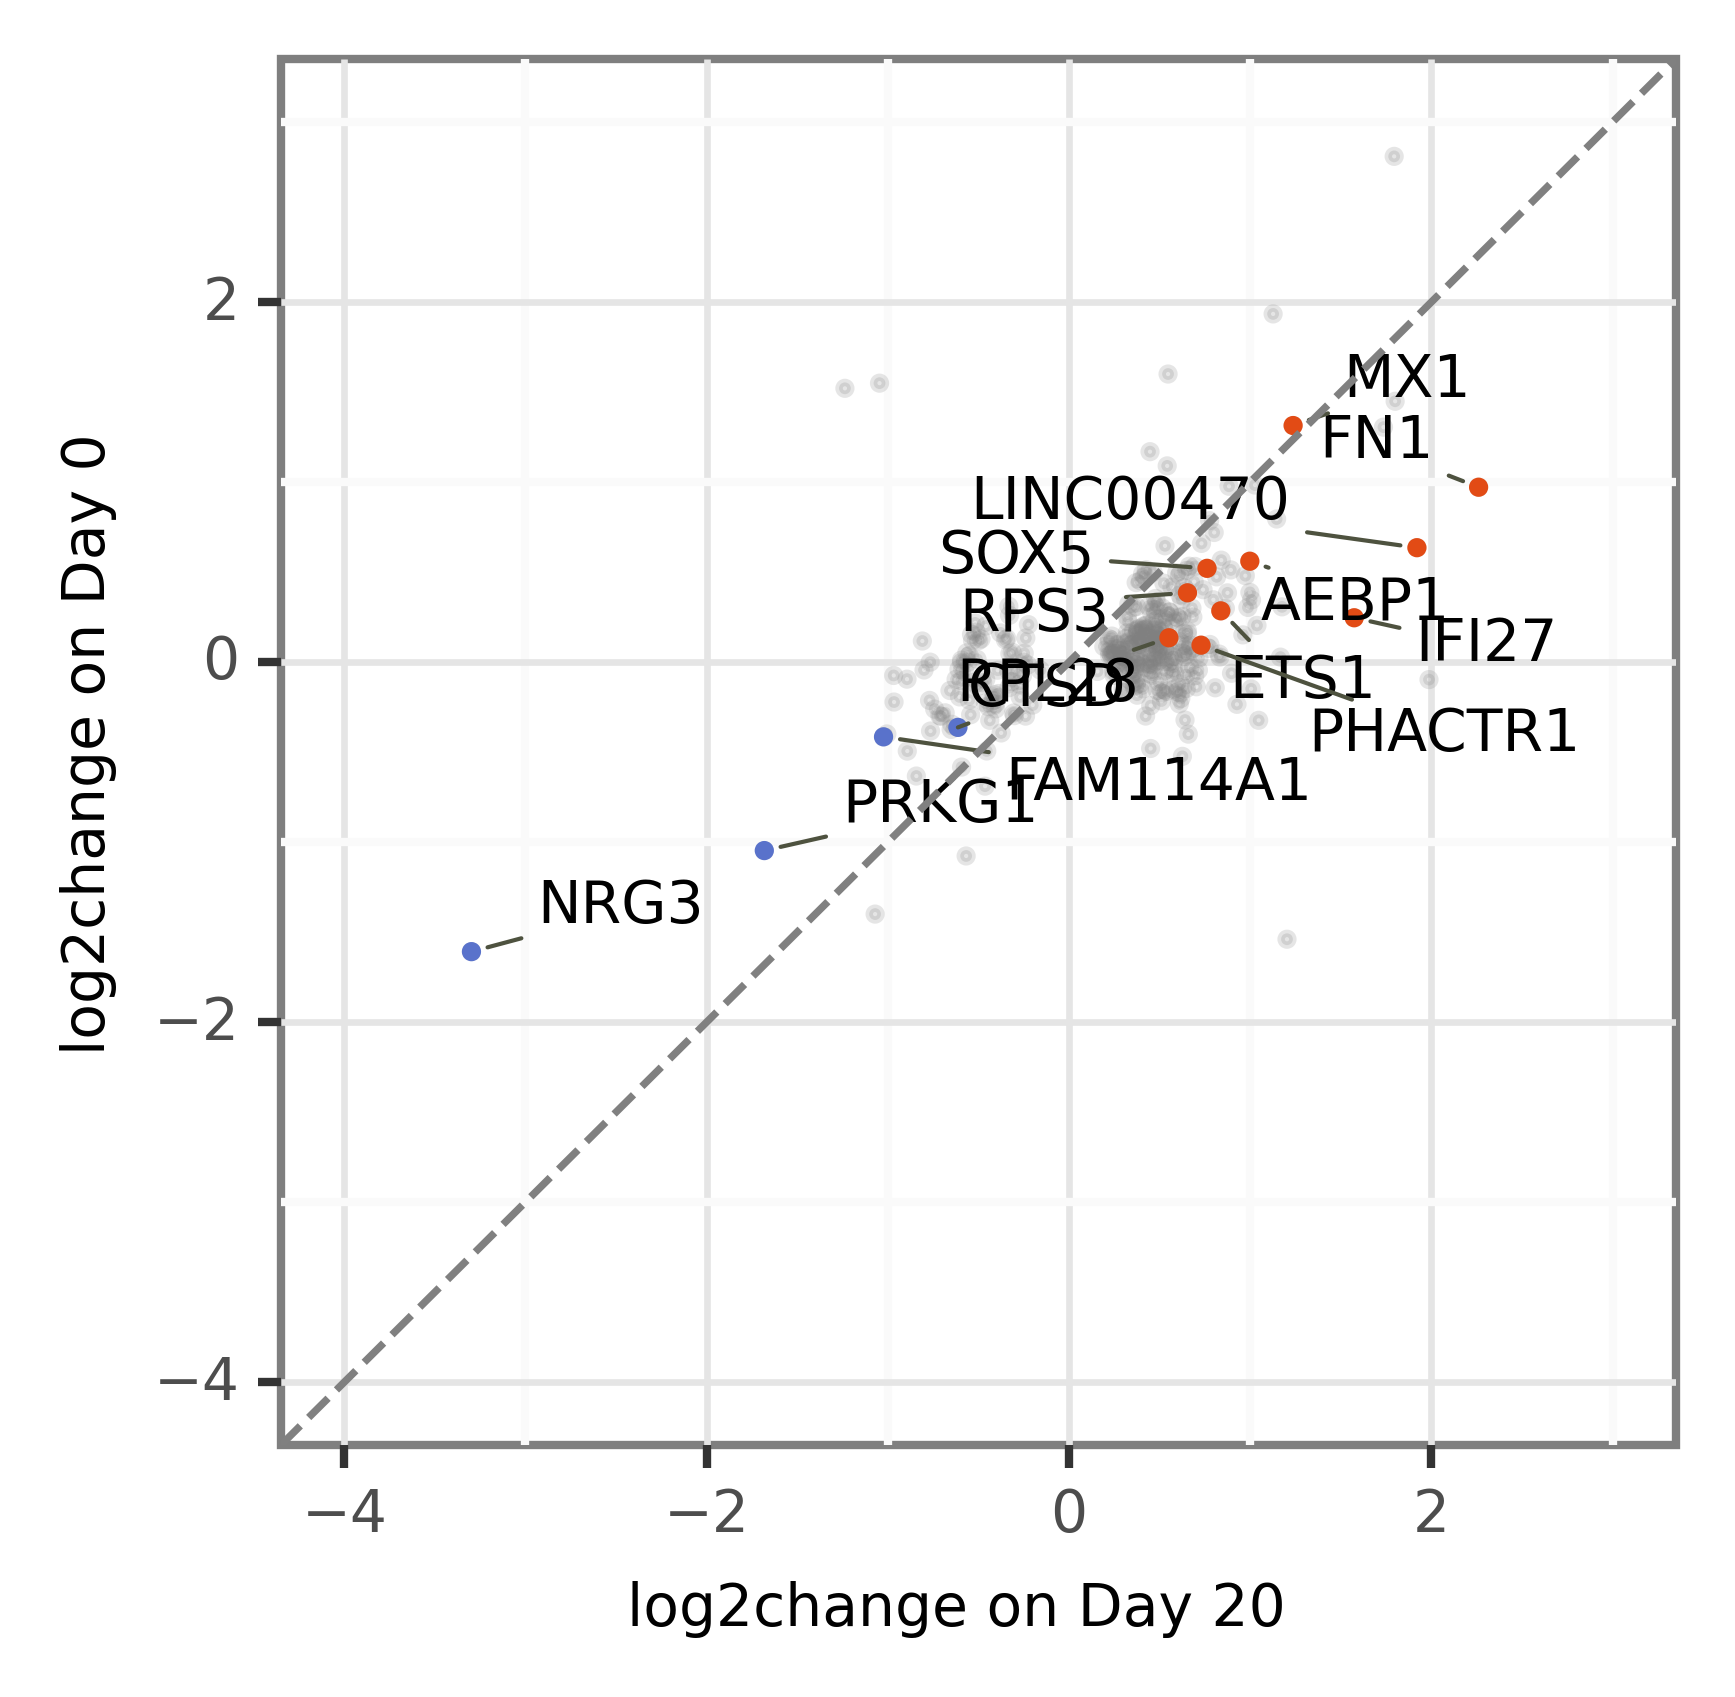

<ggplot: (2932242957605)>

In [29]:
plot=p9.ggplot(data=df_DE_merge_sig,
               mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x')
              )
plot+ p9.geom_point(alpha=0.2,size=0.3,color='grey') \
+ p9.geom_point(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(color='point_color_merge'),size=0.3) \
+ p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
+ p9.themes.theme_bw() \
+ p9.xlim(-4,3) \
+ p9.ylim(-4,3) \
+ p9.xlab('log2change on Day 20') \
    + p9.ylab('log2change on Day 0') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
+ p9.geom_abline(intercept=0,slope=1,linetype='dashed',color='grey') \
    + p9.theme(figure_size=(3,3))

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


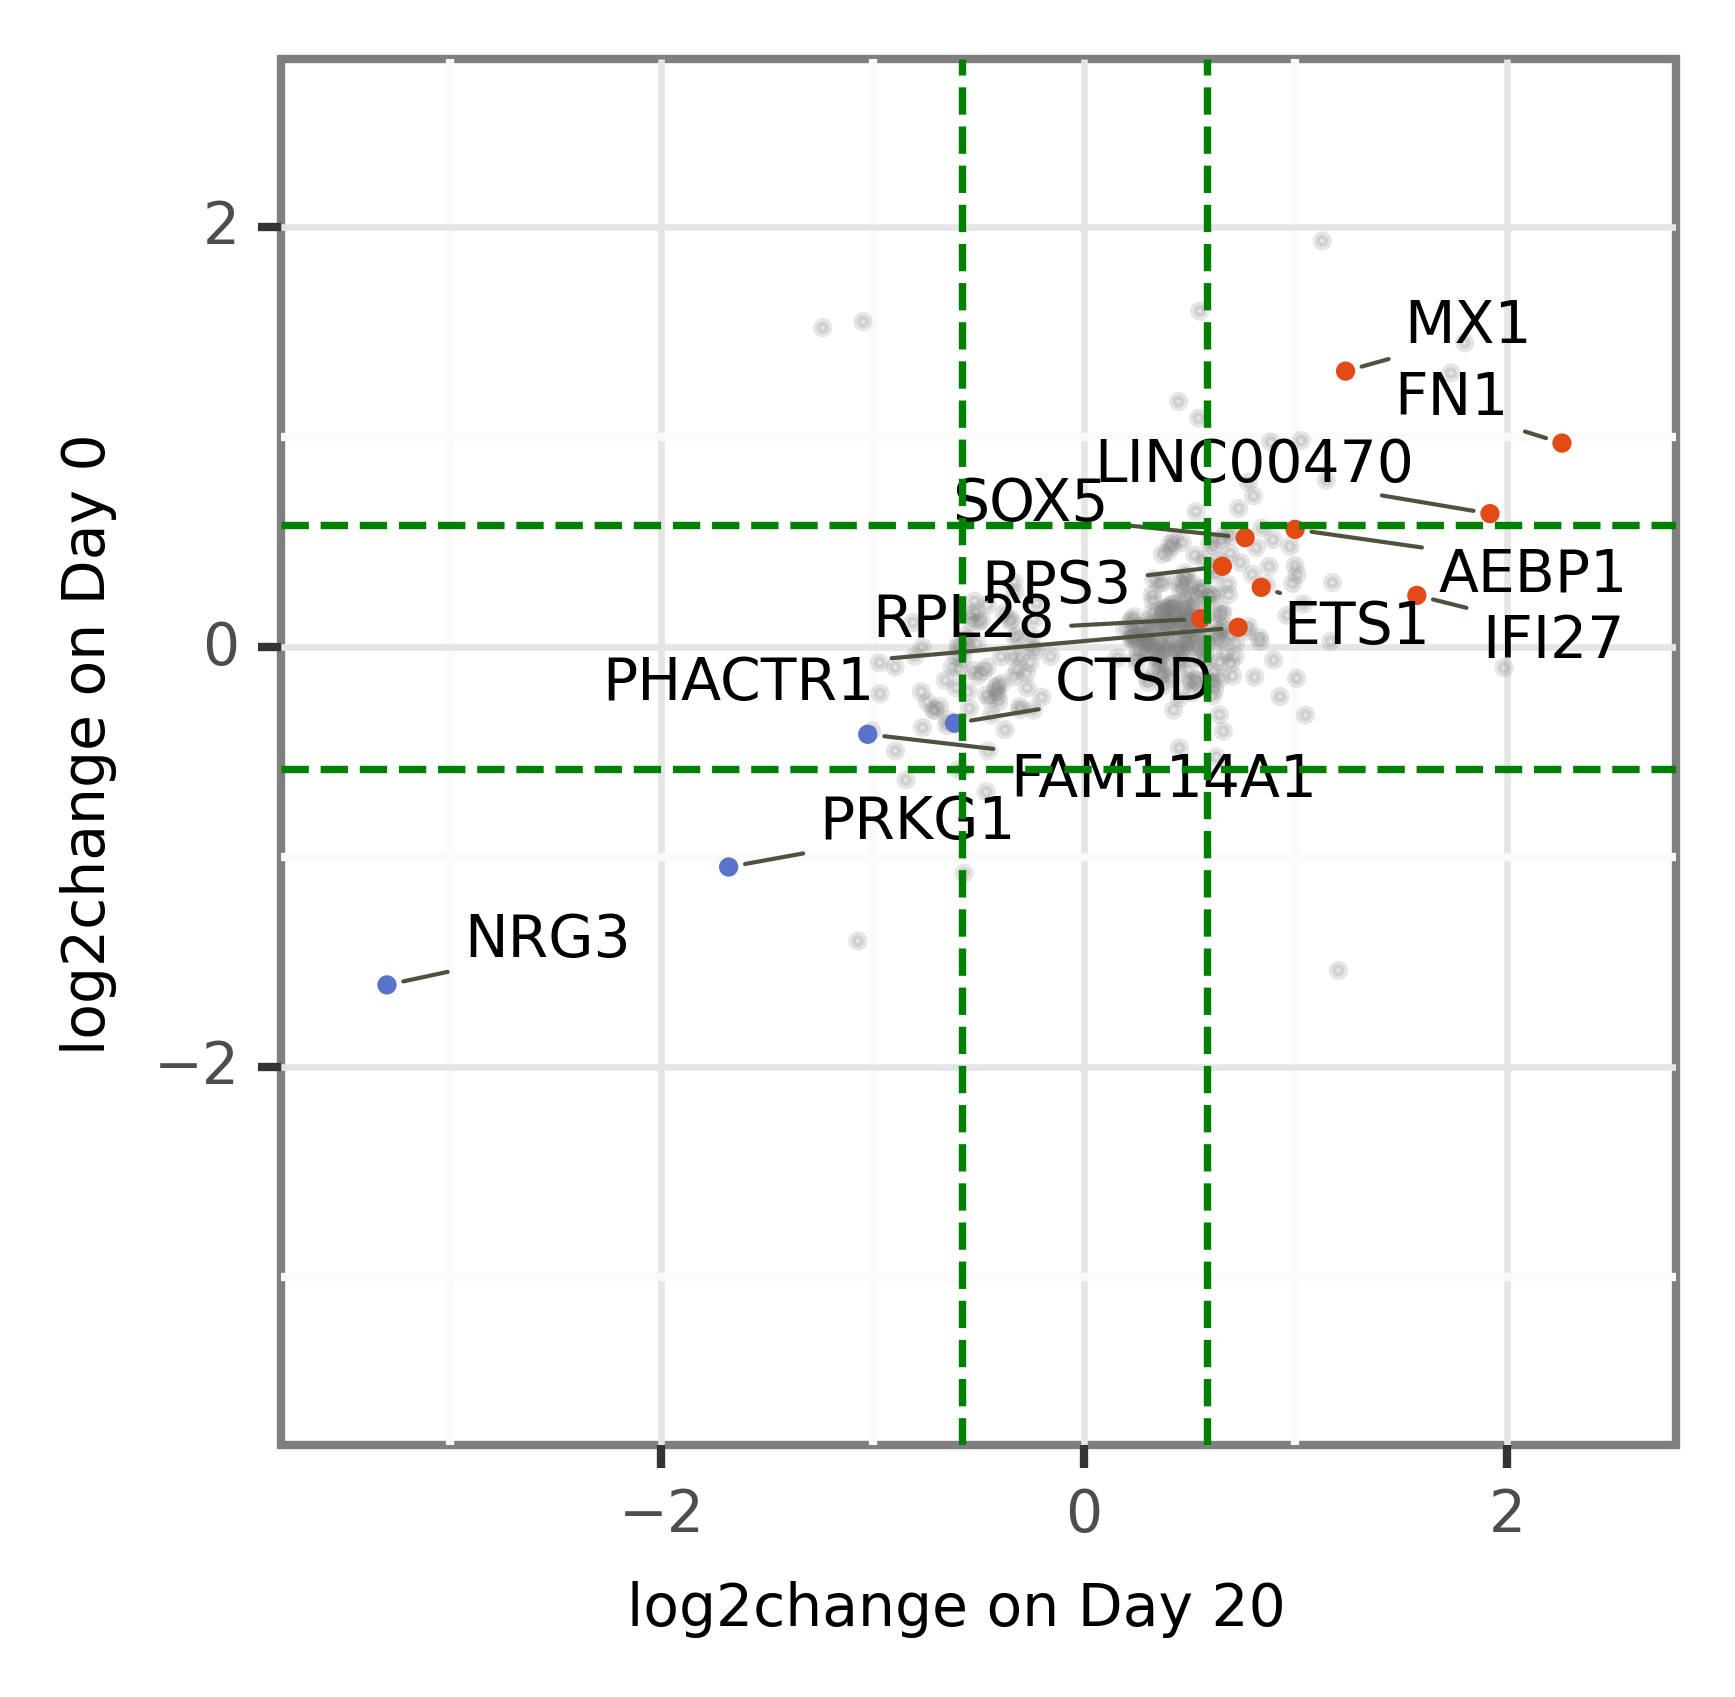

<ggplot: (2932243384814)>

In [30]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color':'#4E523F',
        'lw':0.5
    }
}
plot=p9.ggplot(data=df_DE_merge_sig,
               mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x')
              )
plot+ p9.geom_point(alpha=0.2,size=0.3,color='grey') \
+ p9.geom_point(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(color='point_color_merge'),size=0.3) \
+ p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
+ p9.themes.theme_bw() \
+ p9.xlim(-3.5,2.5) \
+ p9.ylim(-3.5,2.5) \
+ p9.ylab('log2change on Day 0') \
    + p9.xlab('log2change on Day 20') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
+ p9.geom_vline(xintercept=0.58,linetype='dashed',color='green') \
+ p9.geom_vline(xintercept=-0.58,linetype='dashed',color='green') \
+ p9.geom_hline(yintercept=0.58,linetype='dashed',color='green') \
+ p9.geom_hline(yintercept=-0.58,linetype='dashed',color='green') \
+ p9.theme(figure_size=(3,3))

/gstore/home/wub31/.conda/envs/py38_Scanpy_expanded/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


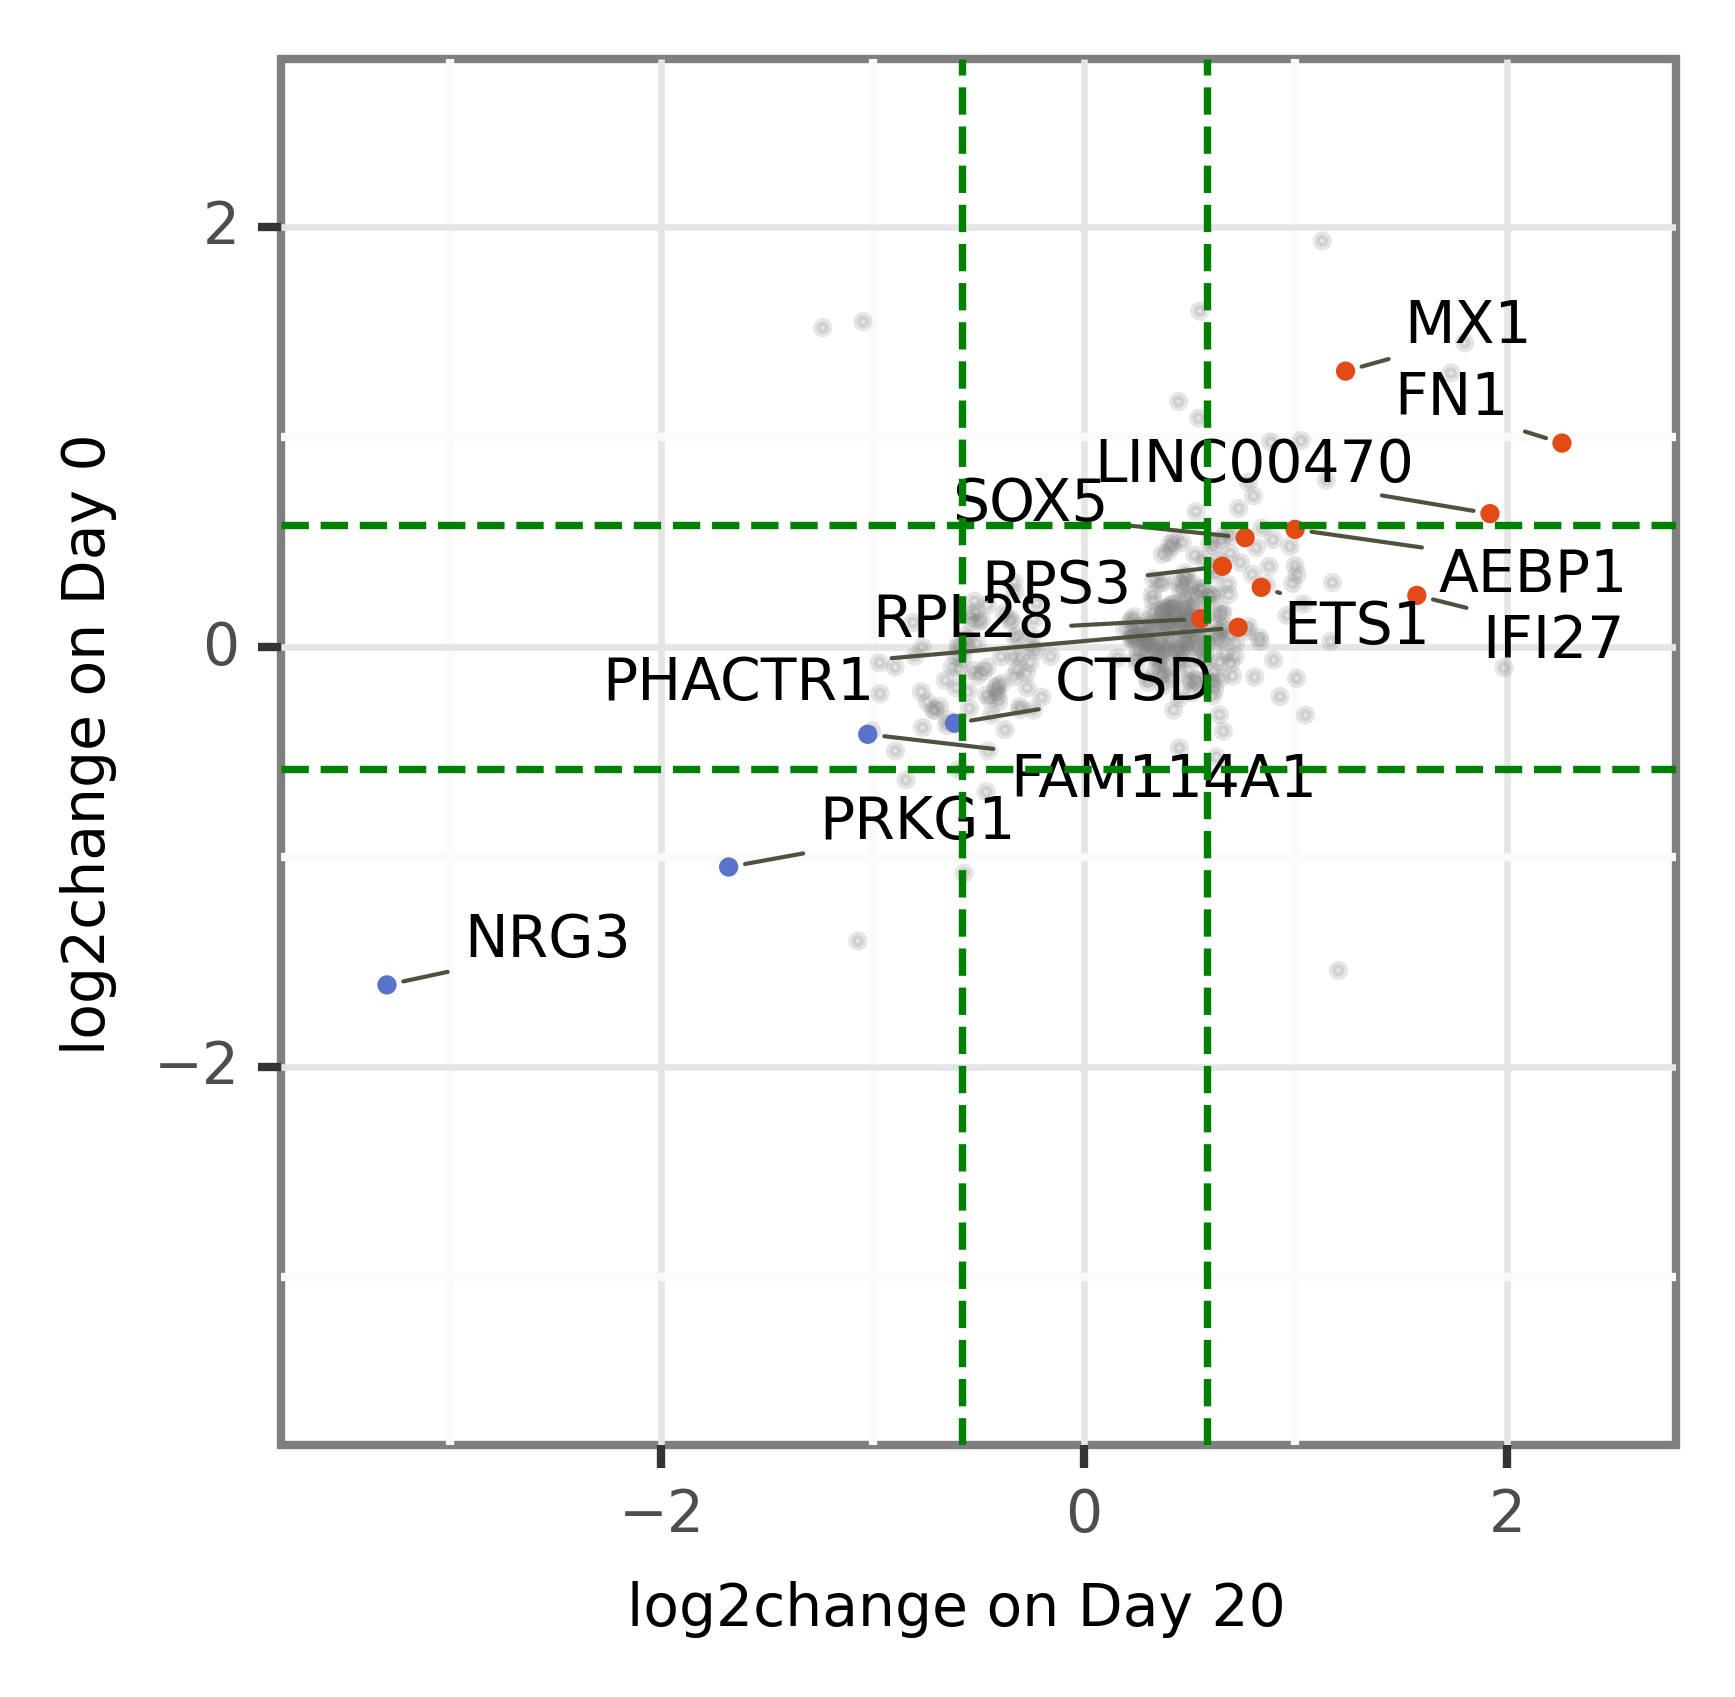

In [31]:
adjust_text_dict = {
    'expand_points': (2, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color':'#4E523F',
        'lw':0.5
    }
}
plot=p9.ggplot(data=df_DE_merge_sig,
               mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x')
              )
plotsave=plot+ p9.geom_point(alpha=0.2,size=0.3,color='grey') \
+ p9.geom_point(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(color='point_color_merge'),size=0.3) \
+ p9.scale_color_manual(values = {'Others':'#4E523F','High_enriched':'#E24B15','High_depleted':'#5972CB'}) \
    + p9.geom_text(data=df_DE_merge_sig[df_DE_merge_sig.GOI_merge==True],mapping=p9.aes(x='Most_enriched_l_y',y='Most_enriched_l_x',label='Most_enriched_n'),size=7,adjust_text=adjust_text_dict) \
+ p9.themes.theme_bw() \
+ p9.xlim(-3.5,2.5) \
+ p9.ylim(-3.5,2.5) \
+ p9.ylab('log2change on Day 0') \
    + p9.xlab('log2change on Day 20') \
    + p9.theme(text=p9.element_text(size=7),legend_position = 'none') \
+ p9.geom_vline(xintercept=0.58,linetype='dashed',color='green') \
+ p9.geom_vline(xintercept=-0.58,linetype='dashed',color='green') \
+ p9.geom_hline(yintercept=0.58,linetype='dashed',color='green') \
+ p9.geom_hline(yintercept=-0.58,linetype='dashed',color='green') \
+ p9.theme(figure_size=(3,3))
fig=plotsave.draw()
points = fig.axes[0].collections[0]
points.set_rasterized(True)
fig.savefig('D20_D0_RasterPt.svg',format='svg',dpi=300)  